# Research Question 1: What is the current performance and scaling of the Superemulator when running 6 and 36 models?

In [2]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [23]:
api = wandb.Api()
#NW_6 = api.runs(f"causalpaca/emulator", filters = {"$or":[{'group' : "NW_Unet"},{'group' : "NW_convlstm"},{'group' : "NW_climax"},{'group' : "NW_climax_frozen"}],'tags': "0_Worker"})

Treatment_6 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "6_models"})
print(len(Treatment_6))
Treatment_36 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "36_models"})
print(len(Treatment_36))
Treatments = [Treatment_6,Treatment_36]
Treatment_Names = ["Treatment_6","Treatment_36"]

8
8


In [19]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      try: 
        name = model.config["model"]["model_name"]
      except:
        name = model.config["model/model_name"]

      # Retrieving system metrics history
      system_metrics = model.history(stream="systemMetrics")
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      defaults = model.history()

      # Scanning history for default metrics
      default_metrics = model.scan_history()
      default_metrics_df = pd.DataFrame(default_metrics)
      still_running = False

      try:
        # Extract the required columns
        val_rmse = default_metrics_df['val/rmse'].ffill()
        val_rmse = val_rmse.bfill().tolist()
        emissions = default_metrics_df['emissions'].dropna().tolist()[0]
        steps = default_metrics_df['_step'].tolist()
      except:
        still_running = True

      if(still_running):
        continue

      # Creating DataFrame for the filtered default metrics and steps
      #val_rmse_df = pd.DataFrame({'val/rmse': val_rmse}).fillna(method='ffill')

      # Extracting runtime values from system metrics
      runtime_values = system_metrics['_runtime']

      print(name,Treatment_Names[index])
      runtime_hours = model.summary["_wandb"].runtime / 60 / 60
      # Create a new DataFrame for the current row
      data.append({
        "treatment": Treatment_Names[index],
        "name": name,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "RSS-Memory in GB": system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list(),
        "RMSE": min(val_rmse),
        "Steps": steps,
        "runtime_hours": runtime_hours,
        "Co2": emissions,
      })
# Convert the list of dictionaries to a DataFrame


unet Treatment_6
climax_frozen Treatment_6
convlstm Treatment_6
climax Treatment_6
unet Treatment_6
climax_frozen Treatment_6
climax Treatment_6
convlstm Treatment_6
convlstm Treatment_36
unet Treatment_36
climax_frozen Treatment_36
climax Treatment_36
convlstm Treatment_36
unet Treatment_36
climax_frozen Treatment_36
climax Treatment_36
climax Treatment_36
climax_frozen Treatment_36
convlstm Treatment_36
unet Treatment_36


In [20]:
runs_count = {}
for d in data:
    key = (d["name"], d["treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('unet', 'Treatment_6'): 2, ('climax_frozen', 'Treatment_6'): 2, ('convlstm', 'Treatment_6'): 2, ('climax', 'Treatment_6'): 2, ('convlstm', 'Treatment_36'): 3, ('unet', 'Treatment_36'): 3, ('climax_frozen', 'Treatment_36'): 3, ('climax', 'Treatment_36'): 3}


In [21]:
# Merge the Multiples
mean_data = {}
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(number_runs)
    print()
    print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    for d in data: 
        if d["name"] == run[0] and d["treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            Steps_Lists.append(d["Steps"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
    
    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "RMSE": statistics.mean(RMSE_Lists),
            "Steps": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")

print(mean_data)

2

unet Treatment_6
2

climax_frozen Treatment_6
2

convlstm Treatment_6
2

climax Treatment_6
3

convlstm Treatment_36
3

unet Treatment_36
3

climax_frozen Treatment_36
3

climax Treatment_36
{('unet', 'Treatment_6'): {'CPU': [0.255, 0.47500000000000003, 0.57, 0.58, 0.585, 0.575, 0.585, 0.575, 0.585, 0.565, 0.58, 0.585, 0.565, 0.59, 0.56, 0.59, 0.58, 0.575, 0.585, 0.575, 0.59, 0.56, 0.575, 0.58, 0.565, 0.58, 0.58, 0.57, 0.575, 0.565, 0.5700000000000001, 0.5700000000000001, 0.585, 0.585, 0.58, 0.57, 0.58, 0.5700000000000001, 0.5700000000000001, 0.58, 0.575, 0.58, 0.56, 0.575, 0.58, 0.74], 'GPU': [0.165, 42.035000000000004, 65.465, 67.57, 67.735, 68.0, 67.53, 62.335, 69.235, 66.765, 66.0, 66.36500000000001, 68.53, 65.6, 62.7, 68.4, 68.3, 71.6, 62.765, 67.065, 66.43, 61.235, 67.4, 69.9, 71.435, 67.5, 68.735, 65.53, 66.13, 64.0, 63.2, 68.83500000000001, 65.3, 68.865, 60.0, 66.53, 62.23, 68.435, 65.965, 63.0, 65.2, 56.364999999999995, 65.965, 65.235, 56.230000000000004], 'RSS-Memory in GB

In [ ]:
a = mean_data.get(("unet", "Treatment_6"),0)
a["Co2"]

0.0010303751683469935

## Overview of Mean, Median and STD

In [22]:
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "RMSE": data_for_run["RMSE"], 
            "runtime_hours": data_for_run["runtime_hours"], 
            "Co2": data_for_run["Co2"]}
        
        rows.append(new_row)


already_used_name=[]
scaling_factor_rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        new_row = {
            "Name":name, 
            "CPU_Mean": statistics.mean(data_for_run_1["CPU"])/statistics.mean(data_for_run_0["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run_1["GPU"])/statistics.mean(data_for_run_0["GPU"]), 
            "RSS-Memory_Mean": statistics.mean(data_for_run_1["RSS-Memory in GB"])/statistics.mean(data_for_run_0["RSS-Memory in GB"]), 
            "RMSE": data_for_run_1["RMSE"]/data_for_run_0["RMSE"], 
            "runtime_hours": data_for_run_1["runtime_hours"]/data_for_run_0["runtime_hours"], 
            "Co2": data_for_run_1["Co2"]/data_for_run_0["Co2"]}
        
        scaling_factor_rows.append(new_row)

new_df = pd.DataFrame(rows)
new_df_sf = pd.DataFrame(scaling_factor_rows)
sorted_df = new_df.sort_values(by='Name')
sorted_df_sf = new_df_sf.sort_values(by='Name')
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
sorted_df = sorted_df.applymap(round_if_float)
sorted_df_sf = sorted_df_sf.applymap(round_if_float)

latex_table = sorted_df.to_latex(index=False,float_format="%.3f")
latex_table_sf = sorted_df_sf.to_latex(index=False,float_format="%.3f")

print(latex_table)
print(latex_table_sf)



\begin{tabular}{llrrrrrrrrrrrr}
\toprule
Name & Treatment & CPU_Mean & CPU_Median & CPU_STD & GPU_Mean & GPU_Median & GPU_STD & RSS-Memory_Mean & RSS-Memory_Median & RSS-Memory_STD & RMSE & runtime_hours & Co2 \\
\midrule
climax & Treatment_6 & 0.429 & 0.430 & 0.032 & 13.176 & 13.817 & 8.416 & 25894.693 & 25886.330 & 5391.429 & 0.628 & 1.766 & 0.001 \\
climax & Treatment_36 & 0.406 & 0.390 & 0.104 & 14.815 & 2.865 & 17.831 & 92832.473 & 93791.340 & 32918.948 & 0.346 & 10.147 & 0.007 \\
climax_frozen & Treatment_6 & 0.506 & 0.480 & 0.093 & 10.805 & 10.818 & 6.715 & 23853.722 & 23921.560 & 4901.973 & 0.487 & 1.711 & 0.001 \\
climax_frozen & Treatment_36 & 0.451 & 0.420 & 0.139 & 14.437 & 11.633 & 15.037 & 93674.538 & 94917.355 & 32051.535 & 0.273 & 9.456 & 0.006 \\
convlstm & Treatment_6 & 0.719 & 0.580 & 0.181 & 12.385 & 9.650 & 7.470 & 11461.723 & 11614.365 & 787.423 & 0.435 & 0.527 & 0.000 \\
convlstm & Treatment_36 & 0.972 & 0.980 & 0.083 & 33.234 & 34.367 & 4.085 & 40542.729 & 40984

C:\Users\fe-na\AppData\Local\Temp\ipykernel_19452\1066113490.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df = sorted_df.applymap(round_if_float)
C:\Users\fe-na\AppData\Local\Temp\ipykernel_19452\1066113490.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_sf = sorted_df_sf.applymap(round_if_float)


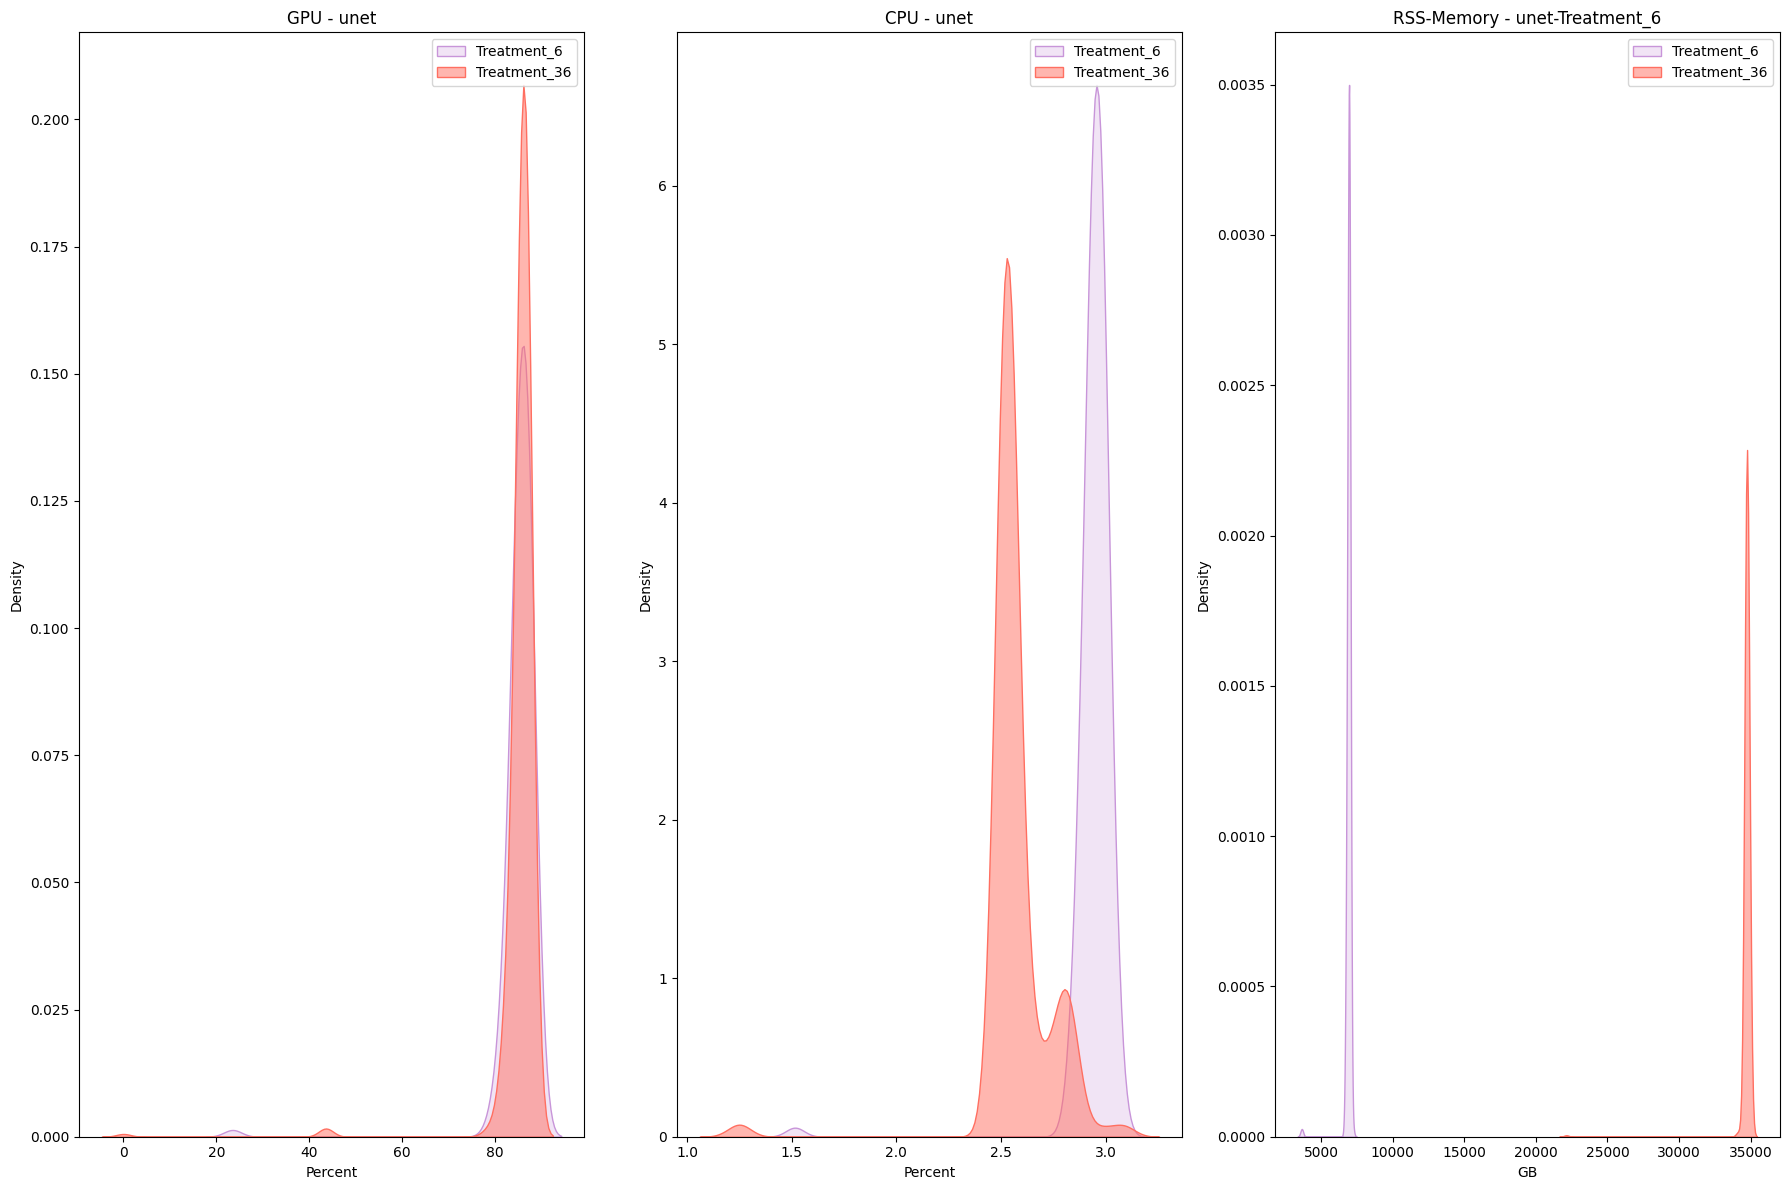

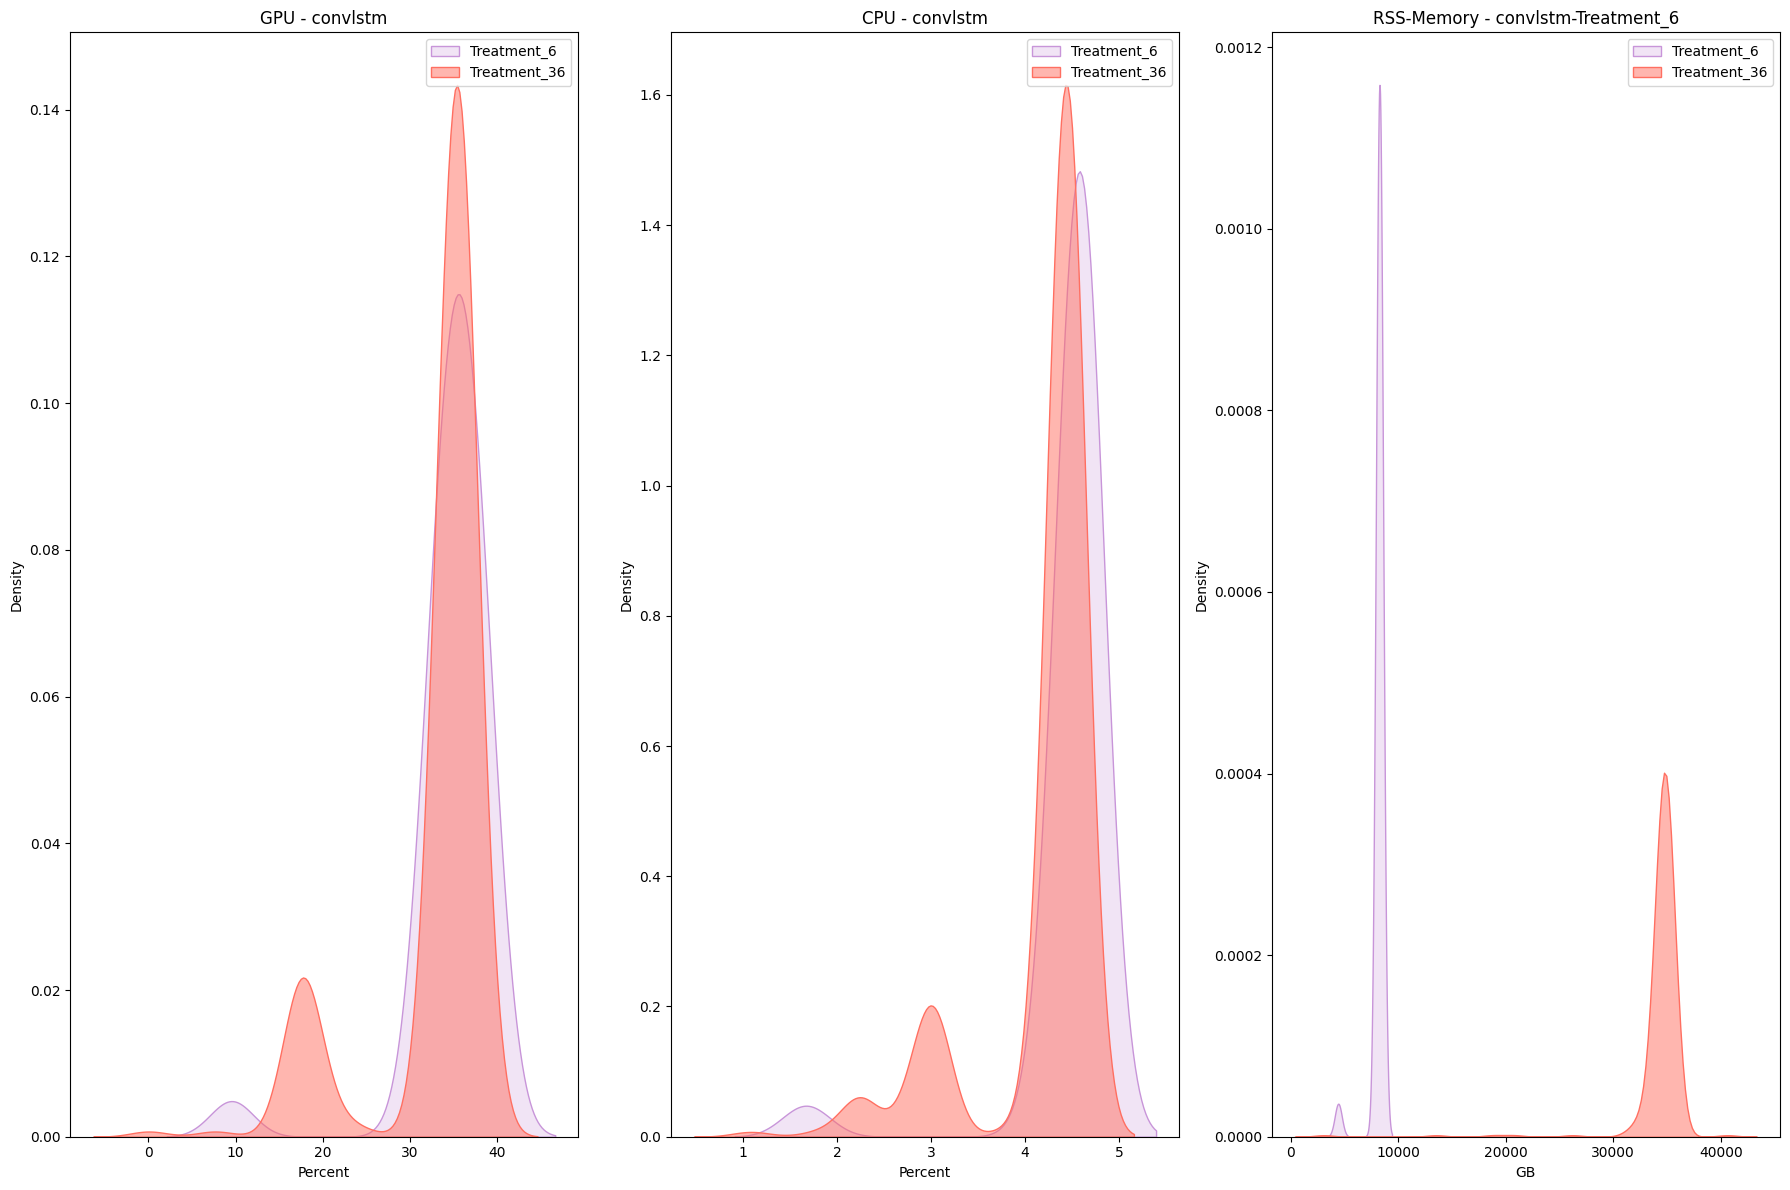

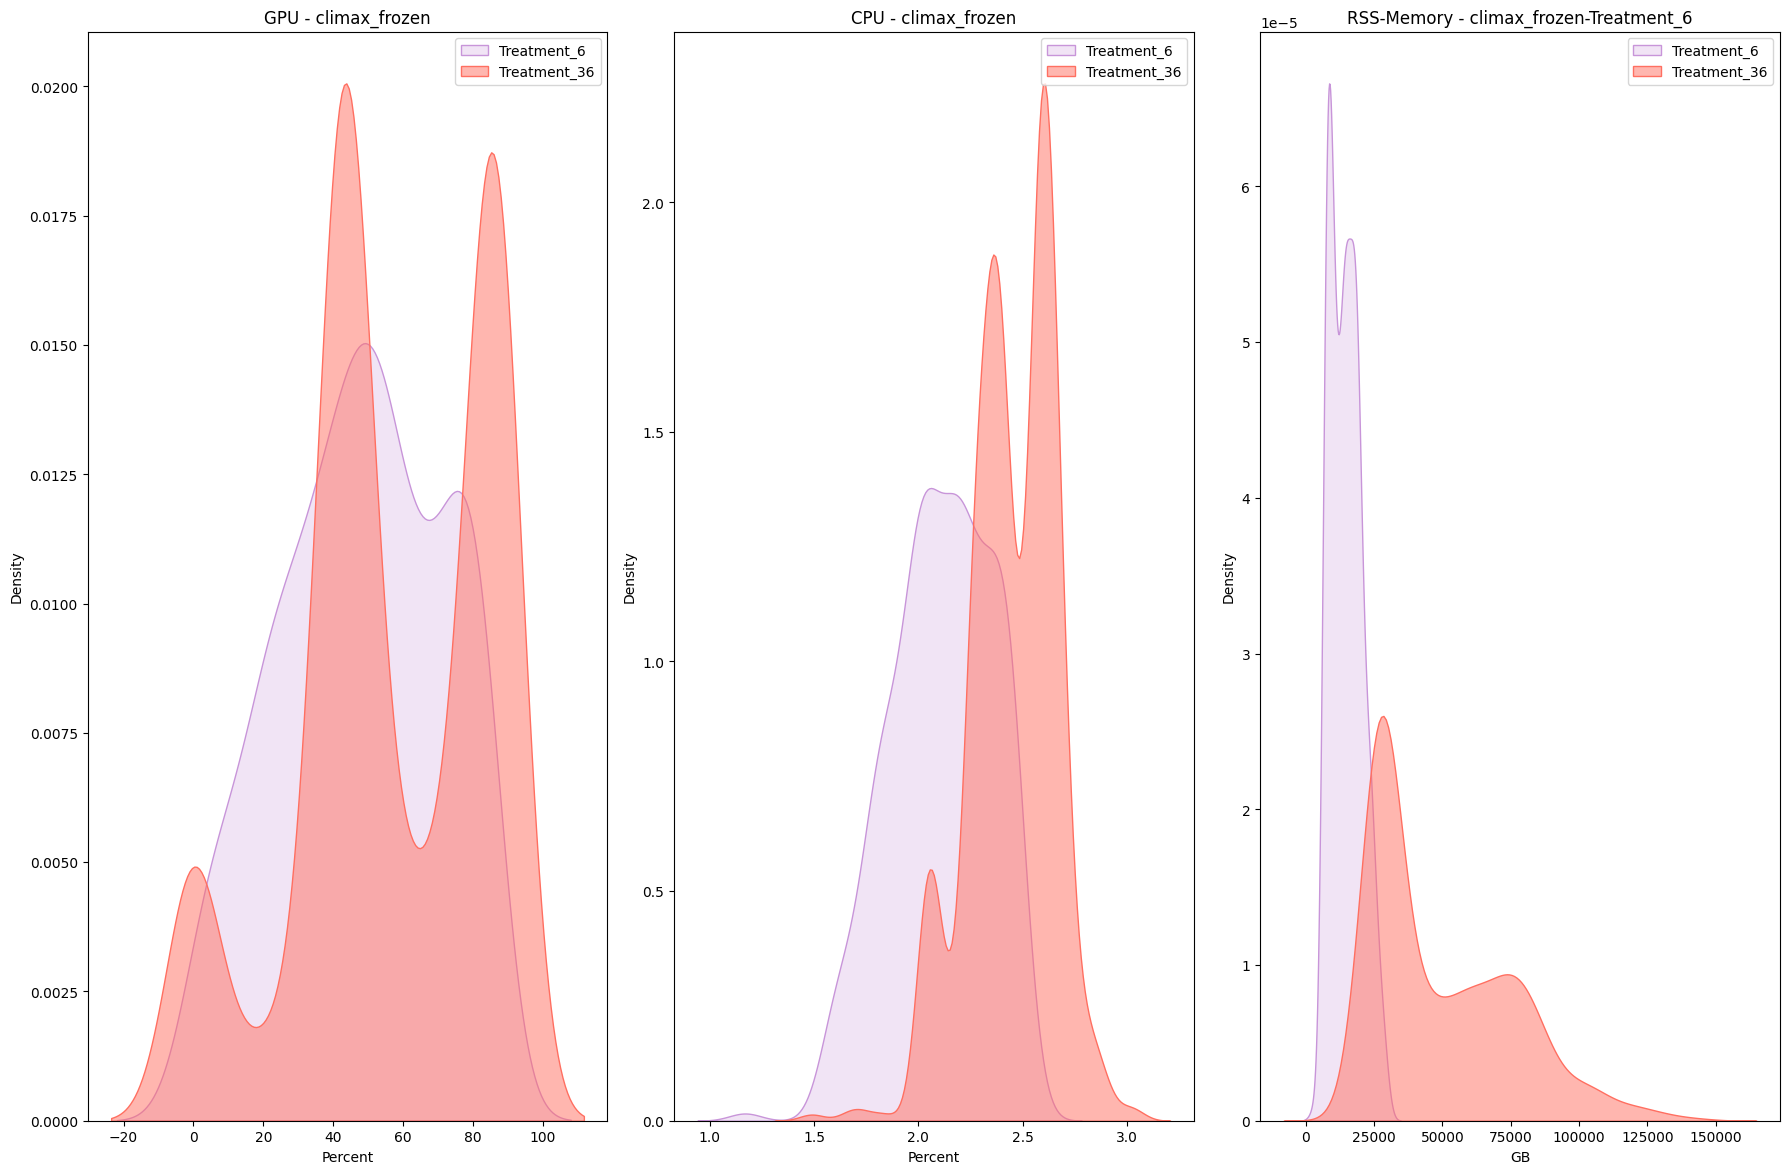

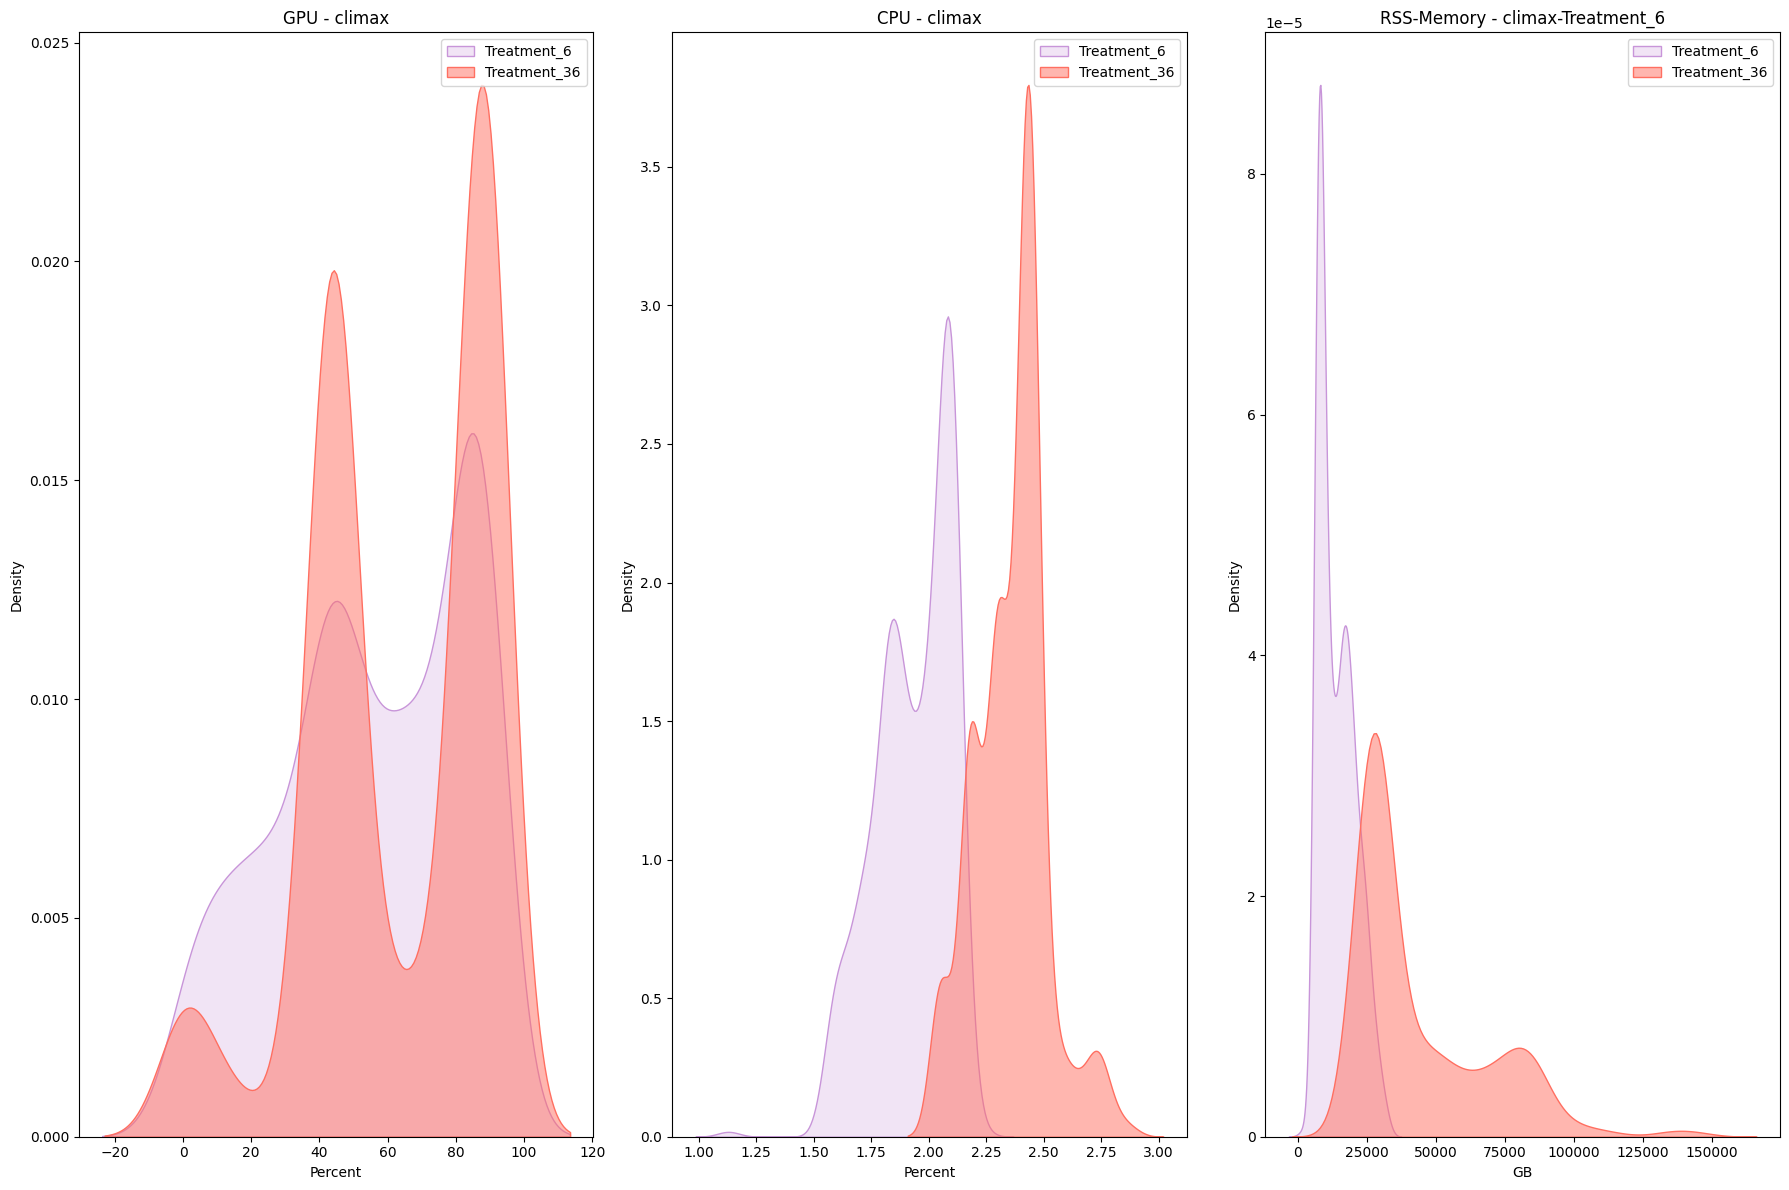

In [ ]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(ax, data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    # sm.qqplot(np.array(data), line ='45') 
    pp = sm.ProbPlot(np.array(data), fit=True)
    qq = pp.qqplot(ax=ax, marker='.', markerfacecolor='k', alpha=0.3, color='#1f77b4')
    sm.qqline(ax=ax, line='45', fmt='k--')
    ax.set_title(name)
    
    

def density_plot_2(ax, treatment_0, treatment_1,name_0,name_1, name, unit):
    sns.kdeplot(data=treatment_0, fill=True, color="#c895d9", ax=ax, label=name_0)
    sns.kdeplot(data=treatment_1, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label=name_1)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
        
#         violin_plot(axes[0, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         density_plot(axes[1, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         plt.tight_layout()
#         fig.savefig(f"figures/RQ_1_violin_density/RQ_1_violin_density_{name}-{treatment}")    

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)

#         fig, axes = plt.subplots(1, 3, figsize=(15, 5),)  # Create a 2x3 grid of subplots

#         qq_plot(axes[0],data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#         qq_plot(axes[1],data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#         qq_plot(axes[2],data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}")

#         fig.savefig(f"figures/RQ_1_QQ/RQ_1_QQ_{name}-{treatment}")        
         # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################


already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

        fig, axes = plt.subplots(1, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots

        density_plot_2(axes[0], data_for_run_0["GPU"],data_for_run_1["GPU"],treatment_0,treatment_1, f"GPU - {run[0]}", "Percent")
        density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"],treatment_0,treatment_1, f"CPU - {run[0]}", "Percent")
        density_plot_2(axes[2], data_for_run_0["RSS-Memory in GB"],data_for_run_1["RSS-Memory in GB"],treatment_0,treatment_1, f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
        plt.tight_layout()
        fig.savefig(f"figures/RQ_1_combined_density/RQ_1_combined_density_{name}-{treatment}")        





In [ ]:
from scipy import stats


data_list_shapiro = []

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if number_runs >= 2:
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]), 0)
        
        SWT_GPU = stats.shapiro(data_for_run["CPU"])
        SWT_CPU = stats.shapiro(data_for_run["GPU"])
        SWT_RSS = stats.shapiro(data_for_run["RSS-Memory in GB"])
        
        data_list_shapiro.append({
            "Name": name,
            "Treatment": treatment,
            "GPU-S": SWT_GPU.statistic,
            "GPU-P": SWT_GPU.pvalue,
            "CPU-S": SWT_CPU.statistic,
            "CPU-P": SWT_CPU.pvalue,
            "RSS-S": SWT_RSS.statistic,
            "RSS-P": SWT_RSS.pvalue
        })

# sorted_df = sorted_df.applymap(round_if_float)
# sorted_df_sf = sorted_df_sf.applymap(round_if_float)

df_Shapiro = pd.DataFrame(data_list_shapiro)
sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)
latex_table_shapiro = sorted_df_shapiro.to_latex(index=False,float_format="%.3f")

print(latex_table_shapiro)
        

\begin{tabular}{llrrrrrr}
\toprule
Name & Treatment & GPU-Statistic & GPU-P & CPU-Statistic & CPU-P & RSS-Statistic & RSS-P \\
\midrule
climax & Treatment_6 & 0.925 & 0.000 & 0.922 & 0.000 & 0.887 & 0.000 \\
climax & Treatment_36 & 0.940 & 0.000 & 0.812 & 0.000 & 0.743 & 0.000 \\
climax_frozen & Treatment_6 & 0.971 & 0.000 & 0.965 & 0.000 & 0.949 & 0.000 \\
climax_frozen & Treatment_36 & 0.955 & 0.000 & 0.857 & 0.000 & 0.835 & 0.000 \\
convlstm & Treatment_6 & 0.248 & 0.000 & 0.564 & 0.000 & 0.192 & 0.000 \\
convlstm & Treatment_36 & 0.522 & 0.000 & 0.580 & 0.000 & 0.214 & 0.000 \\
unet & Treatment_6 & 0.293 & 0.000 & 0.282 & 0.000 & 0.166 & 0.000 \\
unet & Treatment_36 & 0.531 & 0.000 & 0.213 & 0.000 & 0.047 & 0.000 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_16840\60037110.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)


In [ ]:
import pandas as pd
from scipy import stats

def cliffs_delta(lst1, lst2):
    """Calculate Cliff's delta (δ) for non-parametric data."""
    n = len(lst1) * len(lst2)
    m = sum((x > y) for x in lst1 for y in lst2)
    return 2 * m / n - 1

data_list_rank_sum = []
already_used_name = []

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if number_runs >= 2 and (run[0] not in already_used_name):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        SWT_GPU = stats.ranksums(data_for_run_0["CPU"], data_for_run_1["CPU"])
        SWT_CPU = stats.ranksums(data_for_run_0["GPU"], data_for_run_1["GPU"])
        SWT_RSS = stats.ranksums(data_for_run_0["RSS-Memory in GB"], data_for_run_1["RSS-Memory in GB"])

        effect_size_gpu = None
        effect_size_cpu = None
        effect_size_rss = None

        if SWT_GPU.pvalue < 0.05:
            effect_size_gpu = cliffs_delta(data_for_run_0["CPU"], data_for_run_1["CPU"])

        if SWT_CPU.pvalue < 0.05:
            effect_size_cpu = cliffs_delta(data_for_run_0["GPU"], data_for_run_1["GPU"])

        if SWT_RSS.pvalue < 0.05:
            effect_size_rss = cliffs_delta(data_for_run_0["RSS-Memory in GB"], data_for_run_1["RSS-Memory in GB"])

        SWT_GPU_k = stats.kstest(data_for_run_0["CPU"], data_for_run_1["CPU"])
        SWT_CPU_k = stats.kstest(data_for_run_0["GPU"], data_for_run_1["GPU"])
        SWT_RSS_k = stats.kstest(data_for_run_0["RSS-Memory in GB"], data_for_run_1["RSS-Memory in GB"])

        data_list_rank_sum.append({
            "Name": name,
            "GPU-RS-S": SWT_GPU.statistic,
            "GPU-RS-P": SWT_GPU.pvalue,
            "GPU-ES": effect_size_gpu,
            "GPU-KS-S": SWT_GPU_k.statistic,
            "GPU-KS-P": SWT_GPU_k.pvalue,
            "CPU-RS-S": SWT_CPU.statistic,
            "CPU-RS-P": SWT_CPU.pvalue,
            "CPU-ES": effect_size_cpu,
            "CPU-KS-S": SWT_CPU_k.statistic,
            "CPU-KS-P": SWT_CPU_k.pvalue,
            "RSS-RS-S": SWT_RSS.statistic,
            "RSS-RS-P": SWT_RSS.pvalue,
            "RSS-ES": effect_size_rss,
            "RSS-KS-S": SWT_RSS_k.statistic,
            "RSS-KS-P": SWT_RSS_k.pvalue
        })

data_list_rank_sum = pd.DataFrame(data_list_rank_sum)
sorted_df_rank_sum = data_list_rank_sum.sort_values(by='Name').applymap(lambda x: round(x, 3) if isinstance(x, float) else x)
latex_table_rank_sum = sorted_df_rank_sum.to_latex(index=False, float_format="%.3f")

print(latex_table_rank_sum)


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
Name & GPU-RS-S & GPU-RS-P & GPU-ES & GPU-KS-S & GPU-KS-P & CPU-RS-S & CPU-RS-P & CPU-ES & CPU-KS-S & CPU-KS-P & RSS-RS-S & RSS-RS-P & RSS-ES & RSS-KS-S & RSS-KS-P \\
\midrule
climax & -25.440 & 0.000 & -0.957 & 0.932 & 0.000 & -5.479 & 0.000 & -0.208 & 0.226 & 0.000 & -25.580 & 0.000 & -0.962 & 0.962 & 0.000 \\
climax_frozen & -17.354 & 0.000 & -0.710 & 0.586 & 0.000 & -5.353 & 0.000 & -0.220 & 0.310 & 0.000 & -24.079 & 0.000 & -0.981 & 0.975 & 0.000 \\
convlstm & 8.289 & 0.000 & 0.884 & 0.894 & 0.000 & 1.406 & 0.160 & NaN & 0.280 & 0.017 & -9.301 & 0.000 & -0.993 & 0.996 & 0.000 \\
unet & 18.111 & 0.000 & 0.960 & 0.969 & 0.000 & -0.360 & 0.719 & NaN & 0.163 & 0.003 & -18.874 & 0.000 & -1.000 & 1.000 & 0.000 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_16840\3568980733.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_rank_sum = data_list_rank_sum.sort_values(by='Name').applymap(lambda x: round(x, 3) if isinstance(x, float) else x)
